In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import math
import numpy as np
import pandas as pd
import random
import re
import torch
import urllib.request
from torch.utils.data import DataLoader, Dataset
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

In [5]:
train_data = pd.read_excel('/content/drive/MyDrive/감성대화말뭉치(최종데이터)_Training.xlsx')
val_data = pd.read_excel('/content/drive/MyDrive/감성대화말뭉치(최종데이터)_Validation.xlsx')

# 데이터 EDA 및 전처리

In [6]:
# 필요 라이브러리 불러오기
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})

Selecting previously unselected package fonts-nanum.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [7]:
def extract_emotion_with_dialogue(data):
    emotion, human, system = [], [], []

    for _, row in data.iterrows():
        row = [x for x in row if type(x) is not float]
        if len(row) % 2 == 1:
            while len(row) > 1:
                emotion.append(row[0])
                human.append(row.pop(1))
                system.append(row.pop(1))

    return pd.DataFrame({'감정': emotion, '사람문장': human, '시스템문장': system})


train_data = train_data[['감정_소분류', '사람문장1', '시스템문장1', '사람문장2','시스템문장2', '사람문장3', '시스템문장3']]
val_data = val_data[['감정_소분류', '사람문장1', '시스템문장1', '사람문장2','시스템문장2', '사람문장3', '시스템문장3']]

train_data = extract_emotion_with_dialogue(train_data)
val_data = extract_emotion_with_dialogue(val_data)

감정
고립된            5124
혼란스러운          5024
걱정스러운          3475
짜증내는           2978
눈물이 나는         2819
우울한            2814
두려운            2791
억울한            2787
노여워하는          2779
성가신            2752
스트레스 받는        2734
슬픔             2719
괴로워하는          2714
가난한, 불우한       2711
분노             2702
비통한            2687
상처             2655
툴툴대는           2635
한심한            2600
충격 받은          2597
배신당한           2579
후회되는           2556
낙담한            2546
부끄러운           2542
질투하는           2535
초조한            2530
불안             2507
남의 시선을 의식하는    2505
구역질 나는         2501
죄책감의           2498
환멸을 느끼는        2497
안달하는           2484
좌절한            2477
외로운            2475
열등감            2466
취약한            2466
실망한            2464
버려진            2448
당황             2447
조심스러운          2440
회의적인           2416
악의적인           2395
당혹스러운          2389
마비된            2385
희생된            2370
혐오스러운          2369
염세적인           2325
방어적인           2294
기쁨             1835
만족스러운          18

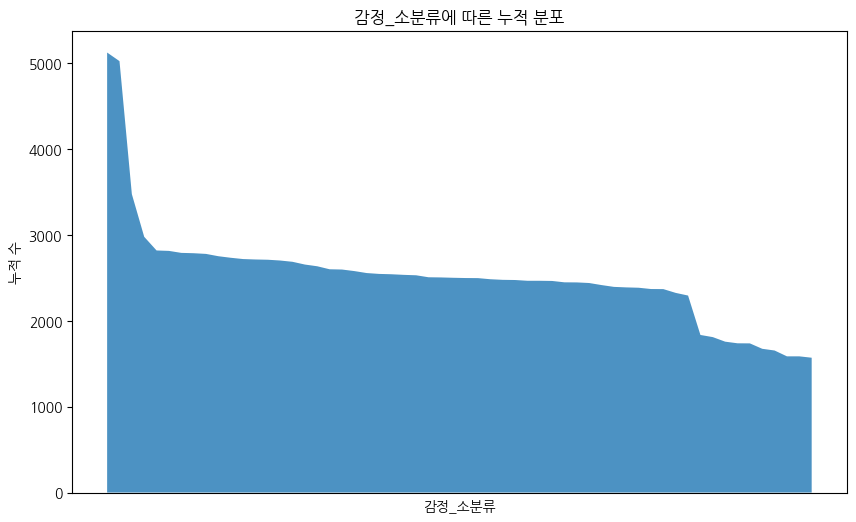

In [8]:
print(train_data['감정'].value_counts(), '\n')

train_data_counts = train_data['감정'].value_counts()
cumulative_train_data = train_data_counts.cumsum()

plt.figure(figsize=(10, 6))
plt.stackplot(train_data_counts.index, train_data_counts.values, labels=train_data_counts.index, alpha=0.8)
plt.xticks([])

plt.title('감정_소분류에 따른 누적 분포')
plt.xlabel('감정_소분류')
plt.ylabel('누적 수')
plt.show()

In [9]:
def top_percentage_ratio(percentage, data_counts):
    total_sum = sum(data_counts)  # 전체 합
    over_threshold = data_counts[:int(len(data_counts)*percentage/100)]
    ratio = sum(over_threshold) / total_sum
    return ratio

top_5_percent_ratio = top_percentage_ratio(5, train_data_counts)
top_10_percent_ratio = top_percentage_ratio(10, train_data_counts)
top_30_percent_ratio = top_percentage_ratio(30, train_data_counts)
top_50_percent_ratio = top_percentage_ratio(50, train_data_counts)

# 결과 출력
print(f"상위 5%에 해당하는 클래스의 전체 데이터 대비 비율: {top_5_percent_ratio:.2%}")
print(f"상위 10%에 해당하는 클래스의 전체 데이터 대비 비율: {top_10_percent_ratio:.2%}")
print(f"상위 30%에 해당하는 클래스의 전체 데이터 대비 비율: {top_30_percent_ratio:.2%}")
print(f"상위 50%에 해당하는 클래스의 전체 데이터 대비 비율: {top_50_percent_ratio:.2%}")

상위 5%에 해당하는 클래스의 전체 데이터 대비 비율: 6.95%
상위 10%에 해당하는 클래스의 전체 데이터 대비 비율: 13.31%
상위 30%에 해당하는 클래스의 전체 데이터 대비 비율: 35.81%
상위 50%에 해당하는 클래스의 전체 데이터 대비 비율: 56.80%


감정 분류가 비교적 고르게 분포해 있음을 알 수 있음

In [10]:
# 메모리의 효율적인 사용 및 학습 효율성 증가를 위해 너무 긴 대화 데이터셋은 제거

# 전체 문장 길이가 100 초과인 행 삭제
train_data['총문장'] = train_data['감정'] + train_data['사람문장'] + train_data['시스템문장']
train_data = train_data[train_data['총문장'].apply(len) <= 100]

train_data = train_data.drop(columns=['총문장']).reset_index()

train_data

,index,감정,사람문장,시스템문장
0,0,노여워하는,일은 왜 해도 해도 끝이 없을까? 화가 난다.,많이 힘드시겠어요. 주위에 의논할 상대가 있나요?
1,1,노여워하는,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,혼자 해결하기로 했군요. 혼자서 해결하기 힘들면 주위에 의논할 사람을 찾아보세요.
2,2,노여워하는,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?
3,3,노여워하는,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,월급이 줄어든 만큼 소비를 줄일 계획이군요.
4,7,노여워하는,직장 사람들과 솔직하게 이야기해보고 싶어. 일하는 데에 방해된다고.,직장 사람들과 이야기를 해 보겠다고 결심하셨군요.
...,...,...,...,...
140163,145945,걱정스러운,이제 할 수 있는 일도 없고 이렇게 힘들게 사는 게 불만스럽기만 해.,지금의 감정을 나아지게 할 수 있는 어떤 방법이 있을까요?
140164,145946,걱정스러운,함께 친하게 지내던 동네 언니 동생들과 빈자리를 조금이나마 채울까 해.,지인분들과 좋은 시간 보내셨으면 좋겠어요.
140165,145947,배신당한,남편과 결혼한 지 사십 년이야. 이제 사람 만나는 것도 버겁고 알던 사람도 점점 사라져.,대인관계에 대한 어려움 때문에 걱정되시고 속상하시겠어요.
140166,145948,배신당한,사람들을 만나는 것이 어려워. 자꾸 사람들을 의심하게만 되고 말이야.,어떻게 하면 지금의 상황에 변화를 만들어낼 수 있을까요?


# kogpt 학습

In [6]:
#토큰값 설정
Q_TKN = '<usr>'
L_TKN = '<emo>'
A_TKN = '<sys>'
BOS = "</s>"
EOS = "</s>"
UNK = "<unk>"
MASK = "<unused0>"
SENT = '<unused1>'
PAD = '<pad>'

In [12]:
class ConversationDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=100):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        instance = self.data.iloc[idx]
        label, question, response = instance['감정'], instance['사람문장'], instance['시스템문장']

        sentence = self.tokenizer.encode(Q_TKN + question + L_TKN + label + A_TKN + response,
                                         max_length=self.max_len,
                                         padding='max_length')

        return torch.tensor([tokenizer.bos_token_id] + sentence + [tokenizer.eos_token_id], dtype=torch.long)

In [51]:
EPOCH = 10
BATCH_SIZE = 64
LEARNING_RATE = 1e-6


tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2", bos_token=BOS, eos_token=EOS, pad_token=PAD)
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')

train_set = ConversationDataset(train_data, tokenizer)
val_set = ConversationDataset(val_data, tokenizer)

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

def lr_lambda(current_step):
    if current_step < len(train_dataloader) // 8:
        return float(current_step) / (len(train_dataloader) // 8)
    return max(0.0, float(EPOCH * len(train_dataloader) - current_step) / (EPOCH * len(train_dataloader) - len(train_dataloader) // 8))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

train_losses = []
val_losses = []

with tqdm(total=(len(train_dataloader) + len(val_dataloader))*EPOCH, desc='Fine-tuning the model') as pbar:
    for epoch in range(EPOCH):
        train_loss = 0
        model.train()

        for batch in train_dataloader:
            optimizer.zero_grad()
            inputs = batch.to(device)
            outputs = model(inputs, labels=inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
            pbar.update(1)

        val_loss = 0
        model.eval()

        with torch.no_grad():
            for batch in val_dataloader:
                inputs = batch.to(device)
                outputs = model(inputs, labels=inputs)
                loss = outputs.loss
                val_loss += loss.item()
                pbar.update(1)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_dataloader)}, Validation Loss: {val_loss / len(val_dataloader)}")

        train_losses.append(train_loss / len(train_dataloader))
        val_losses.append(val_loss / len(val_dataloader))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
Fine-tuning the model:  10%|█         | 2472/24720 [33:05<1:41:45,  3.64it/s]

Epoch 1, Train Loss: 1.4228705609840435, Validation Loss: 0.9148657580711663


Fine-tuning the model:  20%|██        | 4944/24720 [1:06:11<1:30:43,  3.63it/s]

Epoch 2, Train Loss: 0.9301149477048967, Validation Loss: 0.8819943793727834


Fine-tuning the model:  30%|███       | 7416/24720 [1:39:17<1:19:10,  3.64it/s]

Epoch 3, Train Loss: 0.8989609398019199, Validation Loss: 0.8656196307881447


Fine-tuning the model:  40%|████      | 9888/24720 [2:12:23<1:07:31,  3.66it/s]

Epoch 4, Train Loss: 0.8813441970042581, Validation Loss: 0.8552718372531632


Fine-tuning the model:  50%|█████     | 12360/24720 [2:45:28<56:17,  3.66it/s]  

Epoch 5, Train Loss: 0.8705542806020777, Validation Loss: 0.8482181224110288


Fine-tuning the model:  60%|██████    | 14832/24720 [3:18:34<45:08,  3.65it/s]

Epoch 6, Train Loss: 0.8635229946869467, Validation Loss: 0.8440323756258683


Fine-tuning the model:  70%|███████   | 17304/24720 [3:51:40<33:49,  3.65it/s]

Epoch 7, Train Loss: 0.8585263011064882, Validation Loss: 0.8408224837211528


Fine-tuning the model:  80%|████████  | 19776/24720 [4:24:44<22:42,  3.63it/s]

Epoch 8, Train Loss: 0.8550285319115462, Validation Loss: 0.8388363434750838


Fine-tuning the model:  90%|█████████ | 22248/24720 [4:57:40<11:19,  3.64it/s]

Epoch 9, Train Loss: 0.8528716121564331, Validation Loss: 0.8376375237393634


Fine-tuning the model: 100%|██████████| 24720/24720 [5:30:44<00:00,  1.25it/s]

Epoch 10, Train Loss: 0.8517346162058239, Validation Loss: 0.8372646845956714


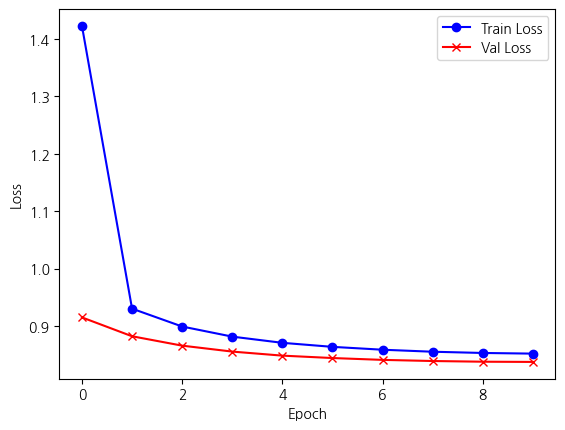

In [52]:
plt.plot(train_losses, label='Train Loss', marker='o', color='blue')
plt.plot(val_losses, label='Val Loss', marker='x', color='red')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [53]:
model_save_path = '/content/drive/MyDrive/kogpt_finetuned.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/kogpt_finetuned.pth


# Chatbot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import math
import numpy as np
import pandas as pd
import random
import re
import torch
import urllib.request
from torch.utils.data import DataLoader, Dataset
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

In [3]:
#토큰값 설정
Q_TKN = '<usr>'
L_TKN = '<emo>'
A_TKN = '<sys>'
BOS = "</s>"
EOS = "</s>"
UNK = "<unk>"
MASK = "<unused0>"
SENT = '<unused1>'
PAD = '<pad>'

In [4]:
class KoGPTChatbot():
    def __init__(self, model, saved_weights_path, tokenizer):
        self.model = model
        self.model.load_state_dict(torch.load(saved_weights_path))
        self.tokenizer = tokenizer

    def start_chat(self):
        print('============================================\n')
        print("대화를 그만하고 싶으면 'quit'을 입력해주세요.\n")
        print('============================================\n')

        while True:
            input_text = input("나: ")

            if input_text != 'quit':
                sentence = self.tokenizer.encode(Q_TKN + input_text + L_TKN)
                tokenized_input = torch.tensor([tokenizer.bos_token_id] + sentence, dtype=torch.long).unsqueeze(0)

                answer = self.model.generate(tokenized_input,
                                             min_length=50,
                                             max_length=200,
                                             repetition_penalty=1.2,
                                             do_sample=True,
                                             no_repeat_ngram_size=5,
                                             temperature=0.03,
                                             top_k=10)

                output = tokenizer.decode(answer[0].numpy().tolist())

                generated = output.split(L_TKN)[1]
                label = generated.split(A_TKN + ' ')[0]
                response = generated.split(A_TKN + ' ')[1].split(PAD)[0]

                print('예상 감정: ', label)
                print('챗봇: ', response, '\n')
            else:
                break

In [9]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2", bos_token=BOS, eos_token=EOS, pad_token=PAD)
base_model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
bot = KoGPTChatbot(base_model, '/content/drive/MyDrive/kogpt_finetuned.pth', tokenizer)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [10]:
bot.start_chat()


대화를 그만하고 싶으면 'quit'을 입력해주세요.


나: 나 오늘 기분이 별로야
예상 감정:  짜증내는
챗봇:  무슨 일이 있으셨나요? 

나: 시험을 망쳤어
예상 감정:  죄책감의
챗봇:  시험이 잘 안 되어서 죄책감이 드시는군요. 

나: quit
